In [1]:
import copy

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler

from loader.DataLoader import read_dataframe
from loader.DataTransformer import lag_list, transform_matrix

from model.RandomForestLstmModel import RandomForestLstmModel
from model.ScalingResidualLstmModel import ScalingResidualLstmModel

In [2]:
import matplotlib.pyplot as plt

In [3]:
# data parameter
LAG = 15
WAVE = 4
REPEAT = 100
START_RATIO = 0.75

### Emsemble Model

In [4]:
def get_file_path(wave: int, filename: str)-> str:
    # curr_dir = os.getcwd()
    # project_dir = curr_dir.split('GitHub')[0]
    # analysis_on_covid_dir = os.path.join(project_dir, 'GitHub', 'analysis-on-covid')
    # return analysis_on_covid_dir + 'checkpoint_wave' + str(wave) + '/' + filename
    return 'checkpoint_wave' + str(wave) + '/' + filename

In [5]:
performance = np.load(get_file_path(WAVE, 'best_train_loss.npy'))

# build model
input_dim = 22
hidden_dim = 64
num_layers = 4
output_dim = 1

models = []
for i in range(REPEAT):
    model = ScalingResidualLstmModel(input_dim, hidden_dim, num_layers, output_dim, LAG)
    model_path: str = get_file_path(WAVE, 'checkpoints/model_{:02d}.chk'.format(i))
    model.load_state_dict(torch.load(model_path))
    models.append(copy.deepcopy(model))

model = RandomForestLstmModel(models, performance)

/tmp/ipykernel_2483/1937806637.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


### Prepare Data

In [6]:
def hypothse(dataframe: pd.DataFrame):
    
    policies = ['school', 'no_hong_kong_p',
       'hong_kong_group', 'hong_kong_all', 'home_other_14', 'home_21',
       'home_14', 'home_7', 'home_3', 'type_1_close', 'type_2_close',
       'type_3_close', 'people2', 'people4', 'people8', '0500_1800',
       '0500_2200', '0500_0200']
    for policy in policies:
        dataframe.loc[:, policy] = 0
    return dataframe

In [7]:
def get_wave_period(wave: int):
    if wave == 1:
        return (52, 103)
    elif wave == 2:
        return (160, 280)
    elif wave == 3:
        return (280, 505)
    elif wave == 4:
        return (757, 871)

In [8]:
def std_column(df: pd.DataFrame, column_name: str)->pd.DataFrame:
    if (df[column_name] == 0).all():
        return df[column_name]
    return (df[column_name] - df[column_name].mean()) / df[column_name].std()

In [9]:
def get_z_norm_count(df: pd.DataFrame, wave:int, lag:int):
    wave_start, wave_end = get_wave_period(WAVE)
    _ = df[wave_start - lag: wave_end]
    return (_['count'].mean(), _['count'].std())

In [10]:
def transform_data(sequence: pd.DataFrame, wave: int, lag: int):    
    # prepare data
    wave_start, wave_end = get_wave_period(WAVE)
    sequence = sequence[wave_start - LAG: wave_end]

    for _ in ['avg_temp', 'avg_humid', 'sum', 'count']:
        sequence.loc[:, _] = std_column(sequence, _)

    shifted_sequence = lag_list(sequence, LAG + 1)  # shift into delayed sequences

    x_train = shifted_sequence[:, :-1, 1:]  # for each delayed sequence, take all elements except last element
    y_train = shifted_sequence[:, -1, -1]  # for each delayed sequence, only take the last element
    y_train = y_train.reshape(-1, 1)

    x_train = torch.from_numpy(x_train.astype('float64')).type(torch.Tensor)  # convert to tensor
    y_train = torch.from_numpy(y_train.astype('float64')).type(torch.Tensor)  # convert to tensor
    
    return x_train, y_train

In [11]:
def simulation(x_train, model, lag:int, start: int):
    # for the first day's input, the prediction is real.  
    # that is to kickstart the ongoing prediction
    x_test = x_train[start].reshape(1,lag, x_train.shape[2]) # get the first input
    y_pred = [ x_test[0][-1][0].detach().numpy().reshape(-1) ] # initialize the list with the first actual count

    prediction_range = len(x_train)

    for i in range(start + 1, prediction_range):
        _ = model(x_test)

        # extract the next input item
        x_test = x_train[i].reshape(1, LAG, x_train.shape[2])

        # append to model prediction list
        _2 = _.detach().numpy()  # revert from tensor
        _2 = _2.reshape(-1)  # reshape back to normal list
        y_pred.append(_2)
        
        # modify the previous day's count to be the prediction
        for j in range(min(len(y_pred), lag)):
            x_test[0][-(j+1)][0] = torch.tensor(y_pred[-(j+1)])
    return y_pred

In [12]:
def get_mse(y_pred: np.ndarray, y_true: np.ndarray)-> float:
    return sum((y_pred - y_true) ** 2) / len(y_true)

In [13]:
def get_rmse(y_pred: np.ndarray, y_true: np.ndarray)-> float:
    return sum((y_pred - y_true) ** 2) / len(y_true) / np.var(y_true)

In [14]:
# prepare data
df_ori = read_dataframe('all')
count_mean, count_std = get_z_norm_count(df_ori, WAVE, LAG)
x_ori, y_train = transform_data(df_ori, WAVE, LAG)

df_mod = hypothse(read_dataframe('all'))
x_mod, _ = transform_data(df_mod, WAVE, LAG)

In [15]:
start_day = int(len(x_ori) * START_RATIO)
print("start day: %d" % start_day)

y_pred_baseline = simulation(x_ori, model, LAG, start_day)
y_pred_simulate = simulation(x_mod, model, LAG, start_day)

# reshape back to normal list
y_pred_baseline = np.array(y_pred_baseline).reshape(-1)  
y_pred_simulate = np.array(y_pred_simulate).reshape(-1)
y_train = np.array(y_train).reshape(-1)

start day: 85


In [16]:
mse_baseline = get_mse(y_pred_baseline, y_train[start_day:])
rmse_baseline = get_rmse(y_pred_baseline, y_train[start_day:])
print("BASELINE | MSE: %.2E | RMSE: %.2E" % (mse_baseline, rmse_baseline))

mse_simulate = get_mse(y_pred_simulate, y_train[start_day:])
rmse_simulate = get_rmse(y_pred_simulate, y_train[start_day:])
print("SIMULATE | MSE: %.2E | RMSE: %.2E" % (mse_simulate, rmse_simulate))

BASELINE | MSE: 1.67E-01 | RMSE: 3.57E+04
SIMULATE | MSE: 1.86E-01 | RMSE: 3.97E+04


### Plot Result

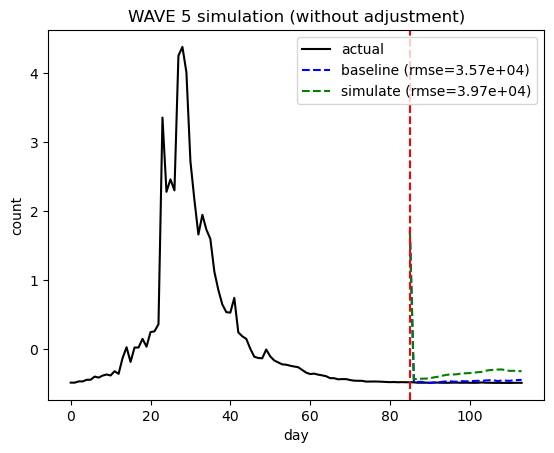

In [17]:
plt.plot(range(len(y_train)), y_train, color='black', label='actual')
plt.plot(range(start_day, len(y_train)), y_pred_baseline, 'b--', label='baseline (rmse={rmse:.2e})'.format(rmse=rmse_baseline))
plt.plot(range(start_day, len(y_train)), y_pred_simulate, 'g--', label='simulate (rmse={rmse:.2e})'.format(rmse=rmse_simulate))
plt.axvline(x=start_day, linestyle='--', color='red')
plt.ylabel("count")
plt.xlabel("day")
plt.title("WAVE %d simulation (without adjustment)" % (WAVE + 1))
plt.legend()
plt.show()

In [18]:
# adjustment for accumulated data
adjustment_factor = 1 - rmse_baseline**2
# y_pred_baseline *= adjustment_factor
# y_pred_simulate *= adjustment_factor
print("adjustment factor %.2f" % adjustment_factor)

# de-normalization
y_pred_baseline = y_pred_baseline * count_std + count_mean
y_pred_simulate = y_pred_simulate * count_std + count_mean
y_train = y_train * count_std + count_mean

adjustment factor -1277921962.66


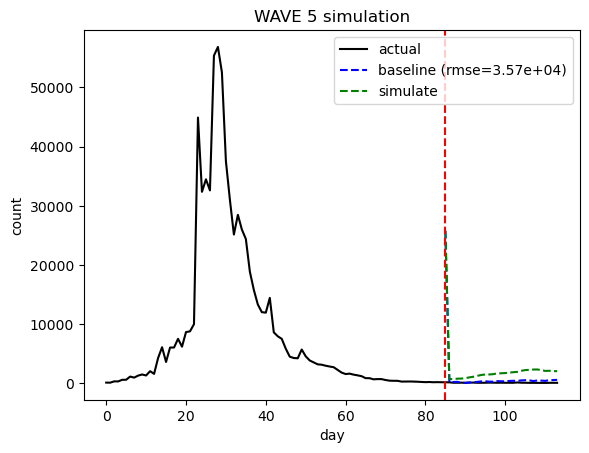

In [19]:
plt.plot(range(len(y_train)), y_train, color='black', label='actual')
plt.plot(range(start_day, len(y_train)), y_pred_baseline, 'b--', label='baseline (rmse={rmse:.2e})'.format(rmse=rmse_baseline))
plt.plot(range(start_day, len(y_train)), y_pred_simulate, 'g--', label='simulate')
plt.axvline(x=start_day, linestyle='--', color='red')
plt.ylabel("count")
plt.xlabel("day")
plt.title("WAVE %d simulation" % (WAVE + 1))
plt.legend()
plt.show()